[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So what field of study would you like to talk about today?", name="Model")]
messages.append(HumanMessage(content=f"I would really like to look into bird-watching",name="Riya"))
messages.append(AIMessage(content=f"Great, any specfic bird you're interested in?", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about countries that have a native caique population ", name="Riya"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So what field of study would you like to talk about today?
================================ Human Message =================================
Name: Riya

I would really like to look into bird-watching
================================== Ai Message ==================================
Name: Model

Great, any specfic bird you're interested in?
================================ Human Message =================================
Name: Riya

I want to learn about countries that have a native caique population 


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [5]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/Lenovo/Documents/code/mat496/.env", override=True) #path to my env folder

True

We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", 
    temperature=0.7,
)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
result

AIMessage(content="Okay, that's a fun and specific topic! Caiques are certainly charismatic birds. Just to clarify, are you asking about countries where caiques naturally occur, as in their *native* range, or countries where they might be kept as pets but are not native? I'm going to assume you mean their native range.\n\nBased on that, the countries with native caique populations are primarily in **South America**. Specifically:\n\n*   **Brazil:** This is a major part of their range. You'll find different caique species in various regions of Brazil.\n*   **Colombia:** Some caique species extend into parts of Colombia.\n*   **Ecuador:** Similar to Colombia, some species' ranges include parts of Ecuador.\n*   **Peru:** Again, some caique species are found in certain regions of Peru.\n*   **Venezuela:** Caiques can be found in Venezuela as well.\n*   **Guyana:** Part of their range extends to Guyana\n*   **Suriname:** Part of their range extends to Suriname\n*   **French Guiana:** Part o

In [8]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'model_name': 'gemini-2.0-flash',
 'safety_ratings': []}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [9]:
!pip install requests

In [10]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: float, b: float) -> float:
    """Divide a by b.
    Args:
        a: numerator
        b: denominator
    """
    if b == 0:
        return "Error: Cannot divide by zero"
    return a / b

def add(a: int, b: int) -> int:
    """Add a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract b from a.
    Args:
        a: first int
        b: second int
    """
    return a - b

def get_current_time() -> str:
    """Get the current date and time.
    No arguments needed.
    """
    from datetime import datetime
    return datetime.now()

def get_weather(location: str) -> str:
    """Get the current weather for a location.
    Args:
        location: city name or location 
    """
    import requests
    
    # Using Open-Meteo API 
    
    geocoding_url = f"https://geocoding-api.open-meteo.com/v1/search?name={location}&count=1&language=en&format=json"
    
    try:
        geo_response = requests.get(geocoding_url)
        geo_data = geo_response.json()
        
        if not geo_data.get("results"):
            return f"Location '{location}' not found"
        
        lat = geo_data["results"][0]["latitude"]
        lon = geo_data["results"][0]["longitude"]
        city_name = geo_data["results"][0]["name"]
        
        # Get weather data
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,weather_code&temperature_unit=celsius"
        weather_response = requests.get(weather_url)
        weather_data = weather_response.json()
        
        temp = weather_data["current"]["temperature_2m"]
        
        return f"Current weather in {city_name}: {temp}°C"
    
    except Exception as e:
        return f"Error getting weather: {str(e)}"

# Bind all tools to the LLM
llm_with_tools = llm.bind_tools([multiply, divide, add, subtract, get_current_time, get_weather])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [11]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Riya")])

In [12]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'b': 3, 'a': 2},
  'id': 'fceb37b9-90c3-4054-9eef-925830033e77',
  'type': 'tool_call'}]

In [13]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 45+64", name="Riya")])

In [14]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'b': 64, 'a': 45},
  'id': '6083d74d-3378-4196-99d2-48704cdef2e2',
  'type': 'tool_call'}]

In [15]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 23-65", name="Riya")])

In [16]:
tool_call.tool_calls

[{'name': 'subtract',
  'args': {'b': 65, 'a': 23},
  'id': '5d693b15-50e2-4cf0-ae7c-40026e7546ef',
  'type': 'tool_call'}]

In [17]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 45 divided by 5", name="Riya")])

In [18]:
tool_call.tool_calls

[{'name': 'divide',
  'args': {'b': 5, 'a': 45},
  'id': 'bc95013e-5450-422a-a259-14d1bc1b3d16',
  'type': 'tool_call'}]

In [19]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is the weather in new york?", name="Riya")])

In [20]:
tool_call.tool_calls

[{'name': 'get_weather',
  'args': {'location': 'new york'},
  'id': '5ed42e18-9263-4607-9079-78099e7276e8',
  'type': 'tool_call'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [21]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [22]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [23]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [24]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on bird-watching.", name="Riya")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='ce2efe9d-08a8-466f-a727-280e359cd2c8'),
 HumanMessage(content="I'm looking for information on bird-watching.", additional_kwargs={}, response_metadata={}, name='Riya', id='e1491e84-c194-45ae-8a59-f55240bc80cd'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='8e127daa-243b-40a3-872a-0955e1a027fb')]

## Our graph

Now, lets use `MessagesState` with a graph.

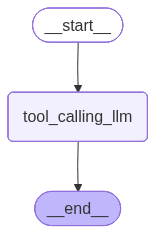

In [25]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [26]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I help you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [27]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (32436784-f8d6-4ac8-8b14-ae4dd18c1230)
 Call ID: 32436784-f8d6-4ac8-8b14-ae4dd18c1230
  Args:
    b: 3
    a: 2


In [28]:
messages = graph.invoke({"messages": HumanMessage(content="Whats the weather in delhi?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Whats the weather in delhi?
================================== Ai Message ==================================
Tool Calls:
  get_weather (f74bb9f9-0d4b-43aa-a0f3-0e11a93a363e)
 Call ID: f74bb9f9-0d4b-43aa-a0f3-0e11a93a363e
  Args:
    location: delhi


In [29]:
messages = graph.invoke({"messages": HumanMessage(content="Whats the time right now?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Whats the time right now?
================================== Ai Message ==================================
Tool Calls:
  get_current_time (f5b5cc31-349c-4d45-a9f8-b6f65645eb83)
 Call ID: f5b5cc31-349c-4d45-a9f8-b6f65645eb83
  Args:
